![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

## Project Goals
- Predict the number of days a customer rents DVDs for.
- Recommend a model yielding a mean squared error (MSE) less than 3 on the test set

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

warnings.filterwarnings('ignore')

## Loading and Preprocessing the dataset

In [5]:
rental_info = pd.read_csv('rental_info.csv', parse_dates=['rental_date','return_date'])

In [6]:
rental_info.head(3)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [7]:
rental_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

### Creating New column total rental days length

In [9]:
rental_info["rental_length_days"] = rental_info.return_date - rental_info.rental_date

In [10]:
rental_info["rental_length_days"] = rental_info["rental_length_days"].dt.days

In [11]:
rental_info.drop(labels=['rental_date', 'return_date'], axis=1, inplace=True)

In [12]:
rental_info.head(3)

,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3
1,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
2,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7


### Handling Categorical class `special_features`

In [14]:
rental_info["behind_the_scenes"] = rental_info['special_features'].str.contains("Behind the Scenes").astype(int)

In [15]:
rental_info["deleted_scenes"] = rental_info['special_features'].str.contains("Deleted Scenes").astype(int)

In [16]:
rental_info.loc[15850:15852]

,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,behind_the_scenes,deleted_scenes
15850,9.99,2004.0,4.99,71.0,26.99,"{Trailers,""Deleted Scenes""}",0,0,0,1,99.8001,5041.0,24.9001,7,0,1
15851,4.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,24.9001,5184.0,8.9401,9,1,0
15852,2.99,2004.0,2.99,72.0,15.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,5184.0,8.9401,2,1,0


In [17]:
rental_info.drop(labels=['special_features'], axis=1, inplace=True)

## Developing Rental Lenght Predicting Model

In [19]:
rental_info.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,behind_the_scenes,deleted_scenes
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,1,0
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,1,0
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,1,0


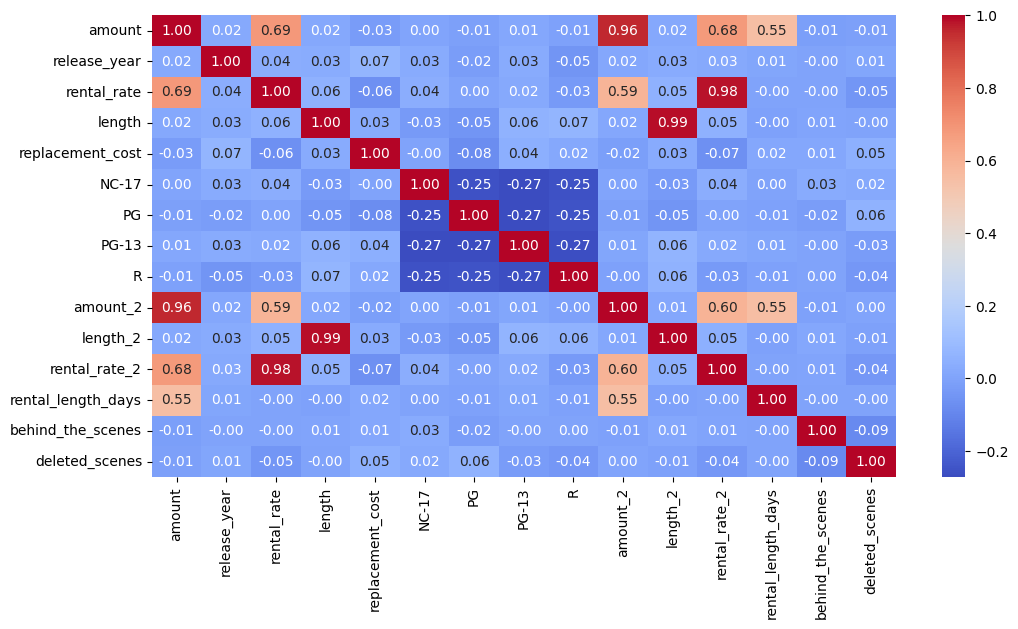

In [20]:
plt.figure(figsize=(12,6))
sns.heatmap(rental_info.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.show()

In [21]:
X = rental_info.drop(labels=['rental_length_days'], axis=1)
y = rental_info['rental_length_days']

In [22]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=.2, random_state=9)

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
reg = LinearRegression()

In [25]:
reg.fit(X_train,y_train)

LinearRegression()

In [26]:
reg.score(X_test, y_test)

0.5856476313096775

In [27]:
mean_squared_error(y_test, reg.predict(X_test))

2.9417238646975505

### Ensembling and Hyperparameter Tuning

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [30]:
ensemble_model = RandomForestRegressor(random_state=9)

In [31]:
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

In [32]:
rand_search = RandomizedSearchCV(ensemble_model, param_distributions=param_dist,  cv=5, random_state=9)

In [33]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=9),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=9)

In [34]:
best_hyperparams = rand_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'n_estimators': 51, 'max_depth': 10}


In [35]:
best_model = rand_search.best_estimator_

In [36]:
best_model.score(X_test, y_test)

0.6864111953564107

In [37]:
y_pred = best_model.predict(X_test)

In [38]:
best_mse = mean_squared_error(y_test, y_pred)
print('Test set MSE of rf: {:.2f}'.format(best_mse))

Test set MSE of rf: 2.23


#### After Hyperparameter Tuning Model Accuracy increased by 10% and MSE reduced by 0.71